In [29]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import scipy.signal as sg
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import preproc as pre
import sk_tricks
import importlib
plt.rcParams['figure.figsize'] = [9, 4]

In [30]:
# Data-ingestion code from NMA data loader
import os, requests

fname = []
for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
    if not os.path.isfile(fname[j]):
        try:
            r = requests.get(url[j])
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
        else:
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")
            else:
                with open(fname[j], "wb") as fid:
                    fid.write(r.content)

alldat = np.array([])
for j in range(len(fname)):
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [31]:
# Pick session
session = 23
dat = alldat[session]
N_cells = dat['spks'].shape[0]
areas = set(dat['brain_area'])
cells_by_area = {area: [i for i in range(N_cells) if dat['brain_area'][i]==area] for area in areas}
Counter(dat['brain_area']) # quick cell census (just for inspection)

Counter({'CA1': 187,
         'CA2': 115,
         'MRN': 80,
         'RSP': 181,
         'SCig': 366,
         'SCsg': 84,
         'VISpm': 146,
         'VISrl': 150,
         'root': 28})

In [14]:
def spike_from_stimulus_type(spikes, contrast, vis_left=dat['contrast_left'], vis_right=dat['contrast_right']):
    '''
    get spikes and a particular contrast type and returns all the trials with this particular contrast values
    '''
    cases = np.array([(i, j) for i in np.unique(vis_right) for j in np.unique(vis_left)])
    trials = []
    for i in range(spikes.shape[1]):
        if (np.array([vis_right[i], vis_left[i]]) == contrast).all():
            trials += [i]
    trials = np.array(trials)
    return trials


In [32]:
# Pick brain areas
area1 = 'VISpm' # will treat this area as Semedo et al. treated V1.
area2 = 'VISrl' # will treat this area as Semedo et al. treated V2.


# Get the raw spike-count data for selected areas
trialsa1 = spike_from_stimulus_type(dat['spks'][cells_by_area[area1],:,:], 
                                    np.array([0, 0.25]), vis_left=dat['contrast_left'], 
                                    vis_right=dat['contrast_right'])
trialsa2 = spike_from_stimulus_type(dat['spks'][cells_by_area[area2],:,:],
                                    np.array([0, 0]), vis_left=dat['contrast_left'], 
                                    vis_right=dat['contrast_right'])
a1 = dat['spks'][cells_by_area[area1],:,:]
a1 = a1[:, trialsa1, :]
a2 = dat['spks'][cells_by_area[area2],:,:]
a2 = a2[:, trialsa2, :]

# Rebin. Original bins 10 ms. Coarsening x10 gives 100 ms.
coarsening = 10
a1_rebinned = pre.rebin(a1, coarsening)
a2_rebinned = pre.rebin(a2, coarsening)

# Select most promising time window. Adriel recommends 0.5 s to 1 s (relative to trial start)
t_start = 5 # inclusive; units are new (coarsened) bins
t_end = 10 # exclusive
a1_rebinned = a1_rebinned[:,:,t_start:t_end]
a2_rebinned = a2_rebinned[:,:,t_start:t_end]

N_bins = a1_rebinned.shape[2]

# Drop quiet cells
min_freq = 0.5
t_bin = 0.01 * coarsening
min_spikes = min_freq * t_bin
a1_trimmed = pre.drop_quiet_cells(a1_rebinned, min_spikes)
a2_trimmed = pre.drop_quiet_cells(a2_rebinned, min_spikes)

Dropped 103 of the original 146 cells
Dropped 87 of the original 150 cells


In [34]:
# Experiment with population matching to find a good value of n_hist_bins. NB the printed output.
# Rough aim: matched populations and source populations should both be repectably large.
# Precise aim: not sure! We might be able to automate this once we have a better sense of what works well.
# NB that the value you settle on for n_hist_bins will be used at the next stage of the analysis.

n_hist_bins = 80 # Fiddle with this! Higher values will tend to lead to smaller matched pops but larger source pop
a1_matched, a2_matched, a1_idx, a2_idx = pre.get_matched_pops(
    a1_trimmed, a2_trimmed, n_hist_bins=n_hist_bins, geometric_bins=True)

Pre-match populations: 43 63
Matched populations: 28 28
Source population: 15


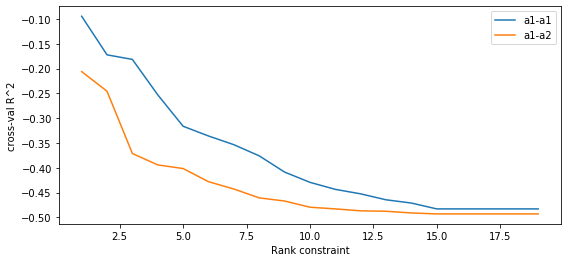

In [37]:
# do cross-validated RRR on repeated matchings
matching_runs = 2
ranks = range(1,20)
cv_folds = 10
a1_a1_r2s = np.empty((matching_runs, len(ranks)))
a1_a2_r2s = np.empty((matching_runs, len(ranks)))

for matching_run in range(matching_runs):

    a1_matched, a2_matched, a1_idx, a2_idx = pre.get_matched_pops(
        a1_trimmed, a2_trimmed, n_hist_bins=n_hist_bins, geometric_bins=True, verbose=False)

    # indices of 'source' V1 neurons should be all those that were not used to match V2 
    a1_source_idx = [i for i in range(a1_trimmed.shape[0]) if i not in a1_idx]
    assert len(a1_source_idx) + len(a1_idx) == a1_trimmed.shape[0]

    # prepare datasets for regression analysis
    
    # Compute PSTHs (and fluctuations around them) with trimmed datasets, i.e. ignoring the quiet cells
    psth1 = a1_trimmed.mean(axis=1).reshape(-1, 1, N_bins)
    psth2 = a2_trimmed.mean(axis=1).reshape(-1, 1, N_bins)
    fluc1 = a1_trimmed - psth1
    fluc2 = a2_trimmed - psth2
    
    flat_flucs1 = fluc1.reshape(fluc1.shape[0],-1)
    flat_flucs2 = fluc2.reshape(fluc2.shape[0],-1)
    X = flat_flucs1[a1_source_idx].T
    Y_v1 = flat_flucs1[a1_idx].T
    Y_v2 = flat_flucs2[a2_idx].T
    
    a1_a1_r2s[matching_run,:] = [cross_val_score(sk_tricks.RRR(rank), X, Y_v1, cv = cv_folds, scoring = sk_tricks.myr2_score).mean() for rank in ranks]
    a1_a2_r2s[matching_run,:] = [cross_val_score(sk_tricks.RRR(rank), X, Y_v2, cv = cv_folds, scoring = sk_tricks.myr2_score).mean() for rank in ranks]

plt.plot(ranks, a1_a1_r2s.mean(axis=0), label='a1-a1')
plt.plot(ranks, a1_a2_r2s.mean(axis=0), label='a1-a2')
plt.ylabel('cross-val R^2')
plt.xlabel('Rank constraint')
_ = plt.legend()

In [7]:
# a quick sanity check
full_rank = min(X.shape[1], Y_v1.shape[1])
full_rank

20

In [8]:
model1 = linear_model.LinearRegression().fit(X,Y_v1)
model2 = sk_tricks.RRR(full_rank).fit(X,Y_v1)
pred1 = model1.predict(X)
pred2 = model2.predict(X)
((pred1 - Y_v1)**2).sum(), ((pred2 - Y_v1)**2).sum()

(2385.679350783769, 2385.679350783769)